In [1]:
# Necessary Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from datetime import datetime
from datetime import timezone
from dateutil import parser
from pathlib import Path

In [2]:
# Importing the youtube data
file_path = r"C:\Users\External Boot\Downloads\Others\YT Analysis Data\youtube_data_4K_channels.csv"
df = pd.read_csv(file_path)

In [3]:
# Importing the monte-carlo simulation data
mc_file_path = r"C:\Users\External Boot\Downloads\Others\YT Analysis Data\mc_simulation_data.csv"
sim_df = pd.read_csv(mc_file_path)

In [4]:
# Importing the cohort analysis data
ch_file_path = r"C:\Users\External Boot\Downloads\Others\YT Analysis Data\cohort_data.csv"
coh_df = pd.read_csv(ch_file_path)

In [5]:
# Importing the bayesian estimate data
by_file_path = r"C:\Users\External Boot\Downloads\Others\YT Analysis Data\bayes_estimate_data.csv"
bay_df = pd.read_csv(by_file_path)

In [6]:
# Importing the kaplan meier estimate data
kp_file_path = r"C:\Users\External Boot\Downloads\Others\YT Analysis Data\kaplan_meier_estimate_data.csv"
kap_df = pd.read_csv(kp_file_path)

In [7]:
# Constructing the function for final estimation
def combine_all_results(
    df_base: pd.DataFrame,
    mc_df: pd.DataFrame,
    bayes_df: pd.DataFrame,
    cohort_df: pd.DataFrame,
    km_df: pd.DataFrame,
    w_mc: float = 0.35,
    w_bayes: float = 0.35,
    w_km: float = 0.20,
    w_expected: float = 0.10
) -> pd.DataFrame:
    
    """
    Combine Monte Carlo, Bayesian, Cohort, and Kaplan–Meier results
    into a single final probability score.
    """

    # Merge everything
    merged = (
        df_base[["channel_id", "current_subscriber_count"]]
        .merge(mc_df, on="channel_id", how="left")
        .merge(bayes_df, on="channel_id", how="left")
        .merge(km_df, on="channel_id", how="left")
        .merge(cohort_df, on="channel_id", how="left")
    )

    # Normalize expected_end_subs to 0–1
    exp_min = merged["expected_end_subs"].min()
    exp_max = merged["expected_end_subs"].max()
    merged["expected_norm"] = (
        (merged["expected_end_subs"] - exp_min) / (exp_max - exp_min + 1e-9)
    )

    # Cohort uplift multiplier (normalized)
    if "cohort_score" in merged.columns:
        cmin = merged["cohort_score"].min()
        cmax = merged["cohort_score"].max()
        merged["cohort_norm"] = (
            (merged["cohort_score"] - cmin) / (cmax - cmin + 1e-9)
        )
    else:
        merged["cohort_norm"] = 1.0

    # Kaplan–Meier probability of reaching 250K
    merged["km_prob_250k"] = 1 - merged["km_survival_prob"]

    # Final probability score (geometric weighted mean)
    merged["final_probability_score"] = (
        (merged["prob_250k_in_horizon"] ** w_mc) *
        (merged["bayes_prob_250k_in_horizon"] ** w_bayes) *
        (merged["km_prob_250k"] ** w_km) *
        (merged["expected_norm"] ** w_expected) *
        (merged["cohort_norm"] ** 0.10)  # small uplift from cohort
    )
    
    # Final probability score (clipped)
    merged["final_probability_score"] = merged["final_probability_score"].clip(0, 1)

    return merged

In [8]:
# FInal combining and estimation
final_df = combine_all_results(
                                df_base=df,
                                mc_df=sim_df,
                                bayes_df=bay_df,
                                cohort_df=coh_df,     
                                km_df=kap_df              
                               )

final_df.sort_values("final_probability_score", ascending=False).head(20)

,channel_id,current_subscriber_count_x,prob_250k_in_horizon,median_days_to_250k,expected_end_subs,end_subs_q10,end_subs_q50,end_subs_q90,horizon_days_x,sims_x,...,reached_250k,time_to_250k_days,growth_rate_per_day,engagement_rate,start_year,age_days,expected_norm,cohort_norm,km_prob_250k,final_probability_score
26,UCX4fV50d398w_YSGgKwa51Q,303000,1.0,1.0,3.480594e+05,3.474852e+05,3.480462e+05,3.486206e+05,1095,1000,...,True,6074.26,41.157294,0.000794,2005,7374,0.009056,1.0,1.000000,0.624733
2720,UCCezIgC97PvUuR4_gbFUs5g,1490000,1.0,1.0,1.719294e+06,1.715978e+06,1.719400e+06,1.722525e+06,1095,1000,...,True,1194.63,209.269663,0.013088,2006,7131,0.044734,1.0,0.266061,0.562420
4324,UCsvqVGtbbyHaMoevxPAq9Fg,5710000,1.0,1.0,6.774581e+06,6.761039e+06,6.774524e+06,6.788631e+06,1095,1000,...,True,257.18,972.080354,0.001373,2009,5885,0.176268,1.0,0.112208,0.542777
2164,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.55,290.511224,0.006677,2011,5313,0.048348,1.0,0.092121,0.458469
4370,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.71,290.456432,0.006678,2011,5313,0.048348,1.0,0.092121,0.458469
4369,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.55,290.511224,0.006677,2011,5313,0.048348,1.0,0.092121,0.458469
2165,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.71,290.456432,0.006678,2011,5313,0.048348,1.0,0.092121,0.458469
4366,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.71,290.456432,0.006678,2011,5313,0.048348,1.0,0.092121,0.458469
4365,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.55,290.511224,0.006677,2011,5313,0.048348,1.0,0.092121,0.458469
2168,UCtYLUTtgS3k1Fg4y5tAhLbw,1540000,1.0,1.0,1.858189e+06,1.853901e+06,1.858223e+06,1.862358e+06,1095,1000,...,True,860.55,290.511224,0.006677,2011,5313,0.048348,1.0,0.092121,0.458469


<Axes: xlabel='final_probability_score', ylabel='Count'>

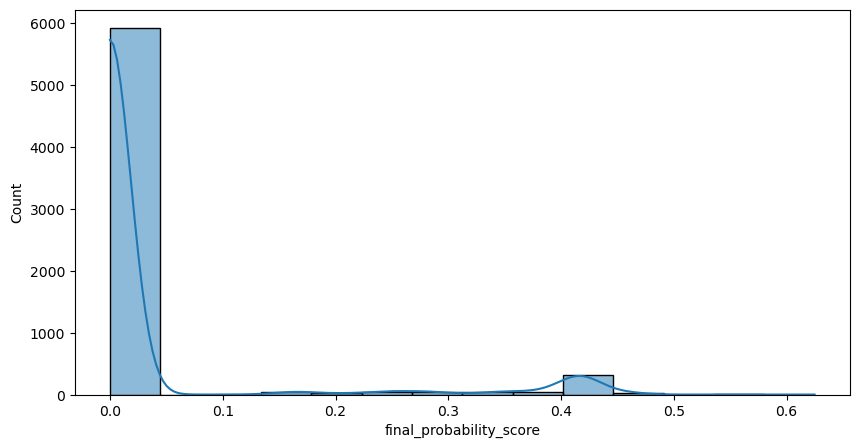

In [13]:
# Quick check on the histplot for distribution check
plt.figure(figsize=(10,5))
sns.histplot(final_df['final_probability_score'], kde=True)

In [10]:
# Considering the 95th percentile value(>being very optimistic)
p95 = final_df["final_probability_score"].quantile(0.95)
print("95th percentile probability score:", round(p95,2))

95th percentile probability score: 0.41
